In [1]:

#dependencies
import numpy as np 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import pandas as pd
import pandas as pd 
import matplotlib.pyplot as plt
import time
from scipy.interpolate import UnivariateSpline

This is a function block which returns the Heisenberg Hamiltonian. It takes the following inputs  
    N = size,   J = coupling,     $h_z$ = magnetic field  
   
   $\mathcal{H} = J [\frac{1}{4}\sum_{\langle i,j \rangle} \left( S_i^x S_j^x + S_i^y S_j^y + S_i^z S_j^z \right) - \frac{1}{2}h_z \sum_{i} S_i^z]$  
     
Here we generate the full sized matrix using $sparse$_$Heisenberg(N,J,h_z)$ and the $spin$ _ $sparse(N)$ module returns the total z-spin

This function generates a sparse Heisenberg matrix, using $scipy.sparse()$ module, which is memory efficient  
  
  In addition, we also obtain the TPQ states iteratively by $multiply()$, and  
    
  the energy expectation values in each step using $expectation()$

In [2]:
#Heisenberg Hamiltonian with the sparse matrix method

# Function to generate the two-site interaction
def kron_identity(site, op, N):
    """Apply operator `op` to the `site`-th spin in a chain of `N` spins."""
    operators = [sp.eye(2, dtype=op.dtype)] * N  # Identity matrices for all sites
    operators[site] = sp.csr_matrix(op)  # Replace with the given operator at `site`

    result = operators[0]
    for op in operators[1:]:
        result = sp.kron(result, op, format='csr')

    del operators

    return result


# Function to generate the sparse spin-z matrix
def spin_sparse(N):

    spin = sp.csr_matrix((2**N, 2**N), dtype=np.complex128)
    Sz = np.array([[1, 0], [0, -1]], dtype=np.float64)  # Sigma_z
    for site in range(N):
        """Construct the Sz operator acting on the `site`-th spin in a chain of `N` spins."""
        # Create identity matrices for all sites except the target site
        operators = [sp.eye(2, dtype=np.float64)] * N  # Identity matrices for all sites
        operators[site] = sp.csr_matrix(Sz)  # Replace with the Sz operator at the target site
    
        # Perform Kronecker product iteratively for all operators
        result = operators[0]
        for op in operators[1:]:
            result = sp.kron(result, op, format='csr')
        spin += result
    
    del operators
    
    return spin
    

#generation of the sparse matrix
def sparse_Heisenberg(N,J,hz):

    # Pauli matrices
    Sx = np.array([[0, 1], [1, 0]], dtype=np.float64)  # Sigma_x
    Sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)  # Sigma_y
    Sz = np.array([[1, 0], [0, -1]], dtype=np.float64)  # Sigma_z

    # Initialize sparse Hamiltonian
    H = sp.csr_matrix((2**N, 2**N), dtype=np.complex128)

    # Build the Heisenberg Hamiltonian (sum over neighboring pairs)
    for i in range(N-1):  # Closed boundary conditions
        j = i+1
        if(i==N-1):
            j = 0
        H += (J/4) * (kron_identity(i, Sx, N) @ kron_identity(j, Sx, N))
        H += (J/4) * (kron_identity(i, Sy, N) @ kron_identity(j, Sy, N))
        H += (J/4) * (kron_identity(i, Sz, N) @ kron_identity(j, Sz, N))

    #Building the transverse field term 
    H -= (J/2) * hz * (spin_sparse(N))
    return H


#function to operate our sparse operator matrix on a dense state
#and return the resulting state
def multiply(operate,vector):

    data = operate.data
    indices = operate.indices
    indptr = operate.indptr

    state = np.zeros(operate.shape[0],dtype=complex)
    for row in range(operate.shape[0]):
        for i in range(indptr[row], indptr[row + 1]):
            col = indices[i]
            state[row] += data[i] * vector[col]
    
    del data,indices,indptr
    
    return state


#function to calculate the expectation value of the given sparse matrix, wrt a given state vector
#and return the expectation value
def expectation(hamiltonian,state_vector):

    opq = multiply(hamiltonian,state_vector)

    expectation_value = np.dot(np.conjugate(state_vector.T),opq)

    return expectation_value

Next we can define the spin-spin correlation operator  
  
  $\phi(j) = \frac{1}{N}\sum_{i}\langle\sigma_z(i)\sigma_z(i+j)\rangle$

 
This function only generates a single term.  
$ \sum_{i} $ is done in the main program

In [3]:
"""Construct a z-spin correlation operator for spins at sites i and j.
    
    Args:
    - N: Total number of spins in the chain.
    - i, j: Sites for the spin operators.
    
    Returns:
    - A sparse matrix representing the z-correlation operator for sites i and j.
    """

def corr_sparse(i,j,N):

    Sz = np.array([[1, 0], [0, -1]], dtype=np.float64)

    correlate = kron_identity(i,Sz,N) @ kron_identity(j,Sz,N)

    return correlate

Here we generate the error term, as discussed  
  
  $\langle (\hat{h} - u_{\kappa})^{2} \rangle = \frac{1}{N |{\xi_{\kappa}''}|} = a $

  and  
$\langle (\hat{h} - u_{\kappa})^{3} \rangle = \frac{\xi_\kappa'''}{N^2 |{\xi_{\kappa}''}|^3} = b $  


Hence, error term equals  
$\frac{\langle (\hat{h} - u_{\kappa})^{3} \rangle}{2 \langle (\hat{h} - u_{\kappa})^{2} \rangle} = \frac{b}{2a}$

  

  Also, we can have corrections for the infinite-sized chain

$\xi_\kappa''' = \frac{b}{N a^3}$ and $\xi_\kappa'' = -|\xi_\kappa''| = -\frac{1}{Na}$ 

or,

$\xi_\kappa''' + \frac{4\kappa}{(l - u_{\kappa}^{\boldsymbol{\cdot}})^3} = \beta''$

and,

$\xi_\kappa'' + \frac{2\kappa}{(l - u_\kappa^{\boldsymbol{\cdot}})^2} = \beta'$

where the correction term is,

$\tilde{u}_\kappa^{\boldsymbol{\cdot}} = u_\kappa^{\boldsymbol{\cdot}} + \frac{\beta''}{2N(\beta')^2}$

In [4]:
#generate the higher derivatives of distribution, given a state
#returns the variance and shift in energy ... uk_dot
#Using sparse matrices

def sparse_distribution(size,h_matrix,energy,state_vector):

    u_matrix = energy * sp.eye(h_matrix.shape[0],dtype=complex)

    ops = h_matrix - u_matrix 
    del u_matrix 

    # Multiplication using non-zero elements
    #(h-u)^2
    state = multiply(ops,state_vector)
    state = multiply(ops,state)

    a = np.conjugate(state_vector.T) @ state

    #(h-u)^3

    state = multiply(ops,state)

    b = np.conjugate(state_vector.T) @ state

    #calculate the correction for the infinite sized systems
    c = -1/(size * a.real)
    d = b.real/(size * (a.real)**3)

    del ops
    
    return b.real/(2*a.real),c,d

This module generates the intital state. It is a uniformly distributed state,  
generated for a spin-chain of N spins

In [5]:
#generating the initial, Haar random state
def haar_random(dim):

    real_part = np.random.normal(0, 1, 2**dim)
    imag_part = np.random.normal(0, 1, 2**dim)
    complex_gaussian_vector = real_part + 1j * imag_part
    
    # Step 2: Normalize the vector
    haar_state = complex_gaussian_vector / np.linalg.norm(complex_gaussian_vector)
    
    return haar_state

#generating a uniformly distributed state
def uniform_state(dim):
    
    theta = np.random.uniform(0,2*np.pi,2**dim)
    
    intital_state = (1/np.sqrt(2**dim))*(np.exp(1.0j*theta)) #initial state defined

    return intital_state

We set the system size N,  
then calculate the TPQ states by successive matrix multiplication,  
List $u_\kappa$ and T($u_\kappa$,N) along with the corrected energy terms  
  
  Note that for the iterative operator, we can set $l = 5J$ or, $l = e_{max}$   

Following variables are stored-  
    1. Energy $u_\kappa$  
    2. Energy $u_\kappa^{\boldsymbol{\cdot}}$  
    3. T as per $u_\kappa$  
    4. T as per $u_\kappa^{\boldsymbol{\cdot}}$  
    5. $\tilde{u}_\kappa^{\boldsymbol{\cdot}}$ for infinite systems

In [ ]:
'''----------------------------------- l = 5J ------------------------------------------'''
'''             comment out lines 9 and 10, add 18,19,20 for l = e_max                  '''

#the TPQ approach, based on the sparse matrix method

N = 12;J = 1.0 #define the system size and coupling
array = [0.0,0.4,0.8] #all magnetic field values

l_val = 5 * J 
l = l_val * sp.eye(2**N, dtype = complex)

Sz_matrix = (1/N) * spin_sparse(N)
for hz in array:

    HM = sparse_Heisenberg(N,J,hz)
    h = (1/N) * HM #hamiltonian constructed

    #max_eigenvalue = spla.eigsh(h, k=1, which='LA', return_eigenvectors=False)
    #l_val = max_eigenvalue[0] 
    #l = l_val * sp.eye(2**N, dtype = complex)

    Psi = uniform_state(N) #initial state defined
    
    #define the iterative operator 
    operate = l - h

    rows=[] #stores the data points
    temp = 100.0
    pow = 0
    while(temp>0.01):
        
        #calculation of TPQ states

        #for l=5J
        Psi = multiply(operate,Psi) 
        Psi = (1/(np.linalg.norm(Psi))) * Psi
        pow +=1
        #calculation of energy values

        #for first process
        u_k = expectation(HM,Psi)
        u_k /= N
        
        #calculation of error terms for a finite sized system
        #for first process
        correction,second,third = sparse_distribution(N,h,u_k.real,Psi)

        u_dot = u_k.real - correction

        temp=(l_val - u_dot)/(2*pow/N)
        temp_err = (l_val - u_k.real)/(2*pow/N)
        
        #calculation of correction for infinite sized system
        #for first process
        numerator = third + (4*pow/N)/((l_val - u_dot)**3)
        denominator = 2 * N * (second + (2*pow/N)/((l_val - u_dot)**2))**2
        u_inf = u_dot + numerator/denominator

        new_row={'u_k':u_k.real,'u_dot':u_dot,'T_err':temp_err,'T':temp,'u_inf':u_inf}
        rows.append(new_row)
    
    df=pd.DataFrame(rows)

    if(hz==0.0):
        df.to_csv('TvsU0.csv', index=False)
    if(hz==0.4):
        df.to_csv('TvsU1.csv', index=False)
    if(hz==0.8):
        df.to_csv('TvsU2.csv', index=False)  

    del h,HM,Psi,rows     

The goal for the next section is to generate magnetization values for fixed $u_\kappa$ values, while varying $h_z$   
$S_z = \sum_{i}\frac{\sigma_z(i)}{N}$ and  
$m_z = \langle \Psi_k|S_z|\Psi_k\rangle$

In [14]:
'''-------------------------------  FOR N = 4,8,12   ----------------------------------------'''
'''                      change the energy values in lines 30 and 33                       '''

N = 12;J = -1.0; err = 0.01 #define the system size and coupling
array = [1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1] #all magnetic field values

Sz_matrix = (1/N) * spin_sparse(N)

l_val2 = 5 * J #required for intitial points
l2 = l_val2 * sp.eye(2**N, dtype = complex)

rows=[] #stores the data points

for hz in array:

    HM = sparse_Heisenberg(N,J,hz)
    h = (1/N) * HM #hamiltonian constructed
    
    max_eigenvalue = spla.eigsh(h, k=1, which='LA', return_eigenvectors=False)
    l_val = max_eigenvalue[0] 
    l = l_val * sp.eye(2**N, dtype = complex) #required for convergence purposes

    Psi = uniform_state(N) #initial state defined
    
    #define the two seperate operators for different regions of spectrum
    operate1 = l - h
    operate2 = l2 - h

    u_dot = 0.0
    while(np.abs(u_dot - 0.25*J)>err):
        
        #calculation of TPQ states
        if(u_dot<0.25*J):
            operate = operate2
        else:
            operate = operate1

        Psi = multiply(operate,Psi) 
        Psi = (1/(np.linalg.norm(Psi))) * Psi
        #calculation of energy values

        #for first process
        u_k = expectation(HM,Psi)
        u_k /= N
        
        #calculation of error terms for a finite sized system
        #for first process
        correction,second,third = sparse_distribution(N,h,u_k.real,Psi)

        u_dot = u_k.real - correction
        print(u_dot)

    mz = expectation(Sz_matrix,Psi)
        
    # u_dot = -1.0 * u_dot
    mz = -1.0 * mz.real
    print("mz=",mz)

        #print(u_dot,temp)

    new_row={'hz':hz,'mz':mz,'u':u_dot}
    rows.append(new_row)
    
df=pd.DataFrame(rows)

if(N==4):
    df.to_csv('MvsH4.csv', index=False)
if(N==8):
    df.to_csv('MvsH8.csv', index=False)
if(N==12):
    df.to_csv('MvsH12.csv', index=False)  

-0.11884060338657984
-0.21769212217632516
-0.29400213775588896
-0.2820806619423999
-0.27040288512745486
-0.25894140733172444
mz= 0.33897140981125223
-0.10746998019286724
-0.2029796240540989
-0.2815143375593808
-0.26970992978793107
-0.2580919312452149
mz= 0.3482900258932331
-0.09293024847410791
-0.17904546952678244
-0.2503712246878206
mz= 0.3476906716067435
-0.08727925979633659
-0.1625448902003501
-0.22616094076371362
-0.2823008703336582
-0.2739431367835993
-0.26565787209132496
-0.25744836181843067
mz= 0.37598916791757764
-0.08346309255231979
-0.15148473181961256
-0.2054913387165859
-0.24939801728660968
mz= 0.36806458756024374
-0.07663139903537622
-0.14008678854414164
-0.19256266982452336
-0.23637284259697622
-0.2718452641681234
-0.26711187895863775
-0.2622984231222599
-0.257405455977705
mz= 0.38667394187353954
-0.0769744326855913
-0.13303579302899463
-0.17846753087799305
-0.2163097592142097
-0.2480421529156852
mz= 0.36847263099381833
-0.07799121035999959
-0.12606369271749812
-0.1633118

Calculation of spin-spin correlation

In [ ]:
'''----------------------- change the u value in line 24 ----------------------------- '''
#Let us calculate the spin-spin correlation for fixed energies
#This is similar to previous part, except that the operator changes 

N = 12; J = 1.0; hz=0.0; err = 0.01 #define the system size and coupling
array = [1,2,3,4,5,6] #all relative correlated positions

l_val = 5 * J #required for intitial points
l = l_val * sp.eye(2**N, dtype = complex)

rows=[] #stores the data points

for j_val in array:

    HM = sparse_Heisenberg(N,J,hz)
    h = (1/N) * HM #hamiltonian constructed

    Psi = uniform_state(N) #initial state defined
    
    #define the convergence operators
    operate = l - h

    u_dot = 0.0
    while(np.abs(u_dot + 0.12*J)>err):

        Psi = multiply(operate,Psi) 
        Psi = (1/(np.linalg.norm(Psi))) * Psi
        #calculation of energy values

        #for first process
        u_k = expectation(HM,Psi)
        u_k /= N
        
        #calculation of error terms for a finite sized system
        #for first process
        correction,second,third = sparse_distribution(N,h,u_k.real,Psi)

        u_dot = u_k.real - correction

    #finding the total correlation operator
    correlation_op = sp.csr_matrix((2**N, 2**N), dtype=np.complex128)

    for k in range(N):
        m = k + j_val
        
        if(m>N-1):
            m = m - N

        correlation_op += corr_sparse(k,m,N)

    Ckm = (1/N) * expectation(correlation_op,Psi)

    new_row={'pos':j_val,'C':Ckm.real,'u':u_dot}
    rows.append(new_row)
    
df=pd.DataFrame(rows)

if(N==4):
    df.to_csv('C4b.csv', index=False)
if(N==8):
    df.to_csv('C8b.csv', index=False)
if(N==12):
    df.to_csv('C12b.csv', index=False)  

-------------------------------------------------------------------------------------------
--------------------------------- PLOTTING T vs u -----------------------------------------

In [ ]:
df1=pd.read_csv('TvsU0.csv')
df2=pd.read_csv('TvsU1.csv')
df3=pd.read_csv('TvsU2.csv')
u1=df1['inf'].values 
u2=df2['inf'].values 
u3=df3['inf'].values 
T1=df1['T'].values 
T2=df2['T'].values 
T3=df3['T'].values
plt.ylabel('T')
plt.xlabel('u')
plt.ylim(0.35,0.75)
plt.xlim(-0.45,-0.25)
plt.title('N=12 antiferro with error')
plt.scatter(u1,T1,s=4.0,label='hz=0')
plt.scatter(u2,T2,s=4.0,label='hz=0.4')
plt.scatter(u3,T3,s=4.0,label='hz=0.8')
plt.legend()
plt.show()

------------------------------- PLOTTING $m_z$ vs $h_z$ -----------------------------------

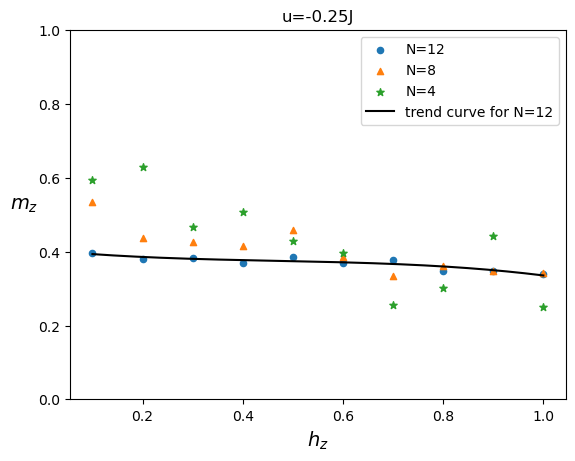

In [15]:
df1=pd.read_csv('MvsH12.csv')
df2=pd.read_csv('MvsH8.csv')
df3=pd.read_csv('MvsH4.csv')
u1=df1['hz'].values 
T1=df1['mz'].values 
u2=df2['hz'].values 
T2=df2['mz'].values 
u3=df3['hz'].values 
T3=df3['mz'].values 

sorted_indices1 = np.argsort(u1)
x_data1 = u1[sorted_indices1]
y_data1 = T1[sorted_indices1]
spline1 = UnivariateSpline(x_data1, y_data1, s=1) 
x_smooth1 = np.linspace(x_data1.min(), x_data1.max(), 500)
y_smooth1 = spline1(x_smooth1)

plt.ylabel(r'$m_z$', rotation=0, labelpad=10,fontsize=14)
plt.xlabel(r'$h_z$',fontsize=14)
plt.ylim(0.0,1.0)
plt.title('u=-0.25J')
plt.scatter(u1,T1,s=20.0,marker='o',label='N=12')
plt.scatter(u2,T2,s=20.0,marker='^',label='N=8')
plt.scatter(u3,T3,s=30.0,marker='*',label='N=4')
plt.plot(x_smooth1, y_smooth1, color='black',label='trend curve for N=12')
plt.legend()
plt.show()

In [ ]:
df1=pd.read_csv('MvsH12.csv')
df2=pd.read_csv('MvsH12a.csv')
df3=pd.read_csv('MvsH12b.csv')
u1=df1['hz'].values 
T1=df1['mz'].values 
u2=df2['hz'].values 
T2=df2['mz'].values 
u3=df3['hz'].values 
T3=df3['mz'].values 

#sorting
sorted_indices1 = np.argsort(u1)
sorted_indices2 = np.argsort(u2)
sorted_indices3 = np.argsort(u3)

x_data1 = u1[sorted_indices1]
y_data1 = T1[sorted_indices1]
x_data2 = u2[sorted_indices2]
y_data2 = T2[sorted_indices2]
x_data3 = u3[sorted_indices3]
y_data3 = T3[sorted_indices3]

#smooth curves
spline1 = UnivariateSpline(x_data1, y_data1, s=1) 
spline2 = UnivariateSpline(x_data2, y_data2, s=1) 
spline3 = UnivariateSpline(x_data3, y_data3, s=1) 

x_smooth1 = np.linspace(x_data1.min(), x_data1.max(), 500)
y_smooth1 = spline1(x_smooth1)

x_smooth2 = np.linspace(x_data2.min(), x_data2.max(), 500)
y_smooth2 = spline2(x_smooth2)

x_smooth3 = np.linspace(x_data3.min(), x_data3.max(), 500)
y_smooth3 = spline3(x_smooth3)

plt.ylabel(r'$m_z$', rotation=0, labelpad=10,fontsize=14)
plt.xlabel(r'$h_z$',fontsize=14)
plt.ylim(0.0,1.0)
plt.title(r'$N = 12$')

plt.scatter(u1,T1,s=20.0,marker='o',label=r'$u = -0.3J$')
plt.scatter(u2,T2,s=20.0,marker='^',label=r'$u = -0.2J$')
plt.scatter(u3,T3,s=30.0,marker='*',label=r'$u = -0.4J$')

plt.plot(x_smooth1, y_smooth1, color='black',label='trend curves')
plt.plot(x_smooth2, y_smooth2, color='black')
plt.plot(x_smooth3, y_smooth3, color='black')

plt.legend()
plt.show()

------------------------------- plotting $\phi(j)$ vs $j$ ---------------------------------

In [ ]:
df1=pd.read_csv('C12.csv')
df2=pd.read_csv('C12a.csv')
df3=pd.read_csv('C12b.csv')
u1=df1['pos'].values 
T1=df1['C'].values 
u2=df2['pos'].values 
T2=df2['C'].values 
u3=df3['pos'].values 
T3=df3['C'].values 
plt.ylabel(r'$\phi(j)$', rotation=0, labelpad=10,fontsize=14)
plt.xlabel(r'$j$',fontsize=14)
#plt.ylim(0.0,1.0)
plt.title('N = 12')
plt.scatter(u1,T1,s=40.0,marker='o',label='u = -0.44J')
plt.scatter(u2,T2,s=40.0,marker='^',label='u = -0.28J')
plt.scatter(u3,T3,s=60.0,marker='*',label='u = -0.12J')

plt.plot(u1,T1,linestyle='--',linewidth=0.8,color='black')
plt.plot(u2,T2,linestyle='--',linewidth=0.8,color='black')
plt.plot(u3,T3,linestyle='--',linewidth=0.8,color='black')

plt.axhline(y=0, color='red', linewidth=0.5)

plt.legend()
plt.show()